In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.layers import Dense,Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

from transformers import TFElectraModel
from transformers import ElectraTokenizer

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [2]:
strategy = tf.distribute.get_strategy()

In [3]:
train = pd.read_csv("data/train.csv", encoding="UTF8")
test = pd.read_csv("data/test.csv", encoding="UTF8")

In [4]:
for i in range(len(train)):
    train['overview'][i] = train['overview'][i].replace('\n','').replace('\t','').replace('\r','').replace('<br>', '').replace('<br />','').replace('*','')
    train['overview'][i] = train['overview'][i].strip()

In [5]:
encoder = LabelEncoder()

encoder.fit(train['cat3'])
train['cat3'] = encoder.transform(train['cat3'])

In [6]:
tokenizer = ElectraTokenizer.from_pretrained("monologg/koelectra-base-v3-discriminator")

In [7]:
train_data = train['overview'].values.tolist()

In [8]:
train_encoded_electra = tokenizer.batch_encode_plus(train_data)

Token indices sequence length is longer than the specified maximum sequence length for this model (1232 > 512). Running this sequence through the model will result in indexing errors


In [9]:
select_length = 500

In [10]:
temp = []
for i in range(len(train_encoded_electra['input_ids'])):
    if len(train_encoded_electra['input_ids'][i]) > select_length:
        temp.append(i)

temp.reverse()

for i in temp:
    train.drop(train.index[i], inplace=True)

In [11]:
train_data = train['overview'].values.tolist()

In [12]:
train_encoded_electra = tokenizer.batch_encode_plus(train_data)

In [13]:
cal_length = train_encoded_electra['input_ids']
num_tokens = [len(tokens) for tokens in cal_length]
num_tokens = np.array(num_tokens)

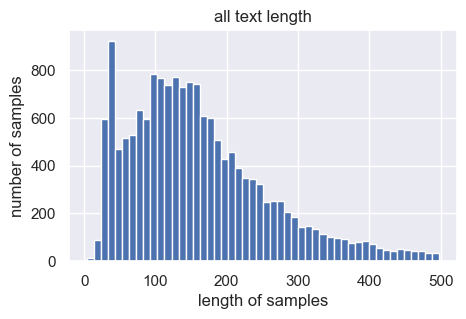

In [14]:
plt.figure(figsize=(5,3))
sns.set_theme(style="darkgrid")
plt.title('all text length')
plt.hist(num_tokens, bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [15]:
train_encoded_electra = tokenizer.batch_encode_plus(train_data, padding='max_length', max_length=500)

In [16]:
x_train, x_valid, y_train, y_valid = train_test_split(train_encoded_electra['input_ids'], train.cat3.values, test_size=0.2,
                                                      stratify=train.cat3 ,random_state=777)

In [17]:
train_dataset = (tf.data.Dataset.from_tensor_slices((x_train, y_train)).repeat().shuffle(2048).batch(4 * strategy.num_replicas_in_sync).prefetch(tf.data.experimental.AUTOTUNE))
valid_dataset = (tf.data.Dataset.from_tensor_slices((x_valid, y_valid)).batch(4 * strategy.num_replicas_in_sync).cache().prefetch(tf.data.experimental.AUTOTUNE))

In [18]:
def model_KoELECTRA():
    encoder = TFElectraModel.from_pretrained("monologg/koelectra-base-v3-discriminator", from_pt=True)

    input_layer = Input(shape=(500,), dtype=tf.int32, name="input_layer")
    sequence_output = encoder(input_layer)[0]

    cls_token = sequence_output[:, 0, :]

    output_layer = Dense(128, activation='softmax')(cls_token)

    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(Adam(lr=1e-5), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [ ]:
model = model_KoELECTRA()

In [ ]:
model.summary()

In [ ]:
checkpoint_path = 'checkpoints/koelectra_cat3/'
checkpoint_dir = os.path.dirname(checkpoint_path)

In [ ]:
cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

In [ ]:
history = model.fit(train_dataset,steps_per_epoch=len(train) // 4 * strategy.num_replicas_in_sync,
                    validation_data=valid_dataset,epochs= 5,
                    callbacks=[cp_callback]
                   )

In [ ]:
plt.figure(figsize=(4,3))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(4,3))
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show()

In [19]:
sub = pd.read_csv("data/sample_submission.csv")

In [20]:
sub.head()

,id,cat3
0,TEST_00000,한식
1,TEST_00001,한식
2,TEST_00002,한식
3,TEST_00003,한식
4,TEST_00004,한식


In [21]:
test.head()

,id,img_path,overview
0,TEST_00000,./image/test/TEST_00000.jpg,신선한 재료로 정성을 다해 만들었다. 늘 변함없는 맛과 서비스로 모실것을 약속한다.
1,TEST_00001,./image/test/TEST_00001.jpg,"청청한 해역 등량만과 율포해수욕장이 한눈에 내려다 보이는 위치에 있으며, 막 잡은 ..."
2,TEST_00002,./image/test/TEST_00002.jpg,장터설렁탕은 남녀노소 누구나 즐길 수 있는 전통 건강식으로 좋은 재료와 전통 조리방...
3,TEST_00003,./image/test/TEST_00003.jpg,다양한 형태의 청소년수련활동을 제공함으로써 청소년들이 민주사회의 주역이 될 수 있도...
4,TEST_00004,./image/test/TEST_00004.jpg,팔공산은 경산시의 북쪽에 위치한 해발 1192.3 m의 높은 산으로 신라시대에는 중...


In [22]:
test_data = test['overview'].values.tolist()

In [23]:
for i in range(len(test)):
    test['overview'][i] = test['overview'][i].replace('\n','').replace('\t','').replace('\r','').replace('<br>', '').replace('<br />','').replace('*','')
    test['overview'][i] = test['overview'][i].strip()

In [24]:
test_encoded_electra = tokenizer.batch_encode_plus(test_data)

In [25]:
cal_length = test_encoded_electra['input_ids']
num_tokens = [len(tokens) for tokens in cal_length]
num_tokens = np.array(num_tokens)

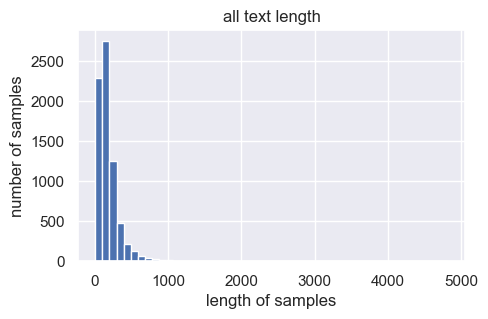

In [26]:
plt.figure(figsize=(5,3))
sns.set_theme(style="darkgrid")
plt.title('all text length')
plt.hist(num_tokens, bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [27]:
# 평균값, 최댓값, 표준편차
print(f"토큰 길이 평균: {np.mean(num_tokens)}")
print(f"토큰 길이 최대: {np.max(num_tokens)}")
print(f"토큰 길이 표준편차: {np.std(num_tokens)}")

토큰 길이 평균: 182.91675824175823
토큰 길이 최대: 4813
토큰 길이 표준편차: 161.5467805361002


In [ ]:
# test_encoded_electra = tokenizer.batch_encode_plus(test_data, padding='max_length', max_length=4850)

In [28]:
test_encoded_electra = tokenizer.batch_encode_plus(test_data, max_length=500, pad_to_max_length='left')

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\transformers\tokenization_utils_base.py:2323: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [30]:
len(test_encoded_electra['input_ids'][0])

500

In [31]:
len(test_encoded_electra['input_ids'][-1])

500

In [32]:
len(test_encoded_electra['input_ids'])

7280

In [33]:
len(test)

7280

In [34]:
x_test = test_encoded_electra['input_ids']
test_dataset = (tf.data.Dataset.from_tensor_slices(x_test).batch(strategy.num_replicas_in_sync))

In [35]:
def pred_model():
    with strategy.scope():
        encoder = TFElectraModel.from_pretrained("monologg/koelectra-base-v3-discriminator", from_pt=True)

        input_layer = Input(shape=(500,), dtype=tf.int32, name="input_layer")
        sequence_output = encoder(input_layer)[0]

        cls_token = sequence_output[:, 0, :]

        output_layer = Dense(128, activation='softmax')(cls_token)

        model = Model(inputs=input_layer, outputs=output_layer)
        model.compile(Adam(lr=1e-5), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [36]:
pred_model = pred_model()

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFElectraModel: ['discriminator_predictions.dense.bias', 'discriminator_predictions.dense.weight', 'discriminator_predictions.dense_prediction.bias', 'electra.embeddings.position_ids', 'discriminator_predictions.dense_prediction.weight']
- This IS expected if you are initializing TFElectraModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFElectraModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFElectraModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFElectraModel for predictions without further train

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: '<' not supported between instances of 'str' and 'Literal'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: '<' not supported between instances of 'str' and 'Literal'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [37]:
pred_model.load_weights('checkpoints/koelectra_cat3/')

In [38]:
pred = pred_model.predict(test_dataset, verbose=1)
pred_arg = pred.argmax(axis=1)

7280/7280 [==============================] - 319s 44ms/step


In [39]:
pred_arg

array([118, 118, 118, ...,  73,  31,  44], dtype=int64)

In [40]:
sub.head()

,id,cat3
0,TEST_00000,한식
1,TEST_00001,한식
2,TEST_00002,한식
3,TEST_00003,한식
4,TEST_00004,한식


In [41]:
test

,id,img_path,overview
0,TEST_00000,./image/test/TEST_00000.jpg,신선한 재료로 정성을 다해 만들었다. 늘 변함없는 맛과 서비스로 모실것을 약속한다.
1,TEST_00001,./image/test/TEST_00001.jpg,"청청한 해역 등량만과 율포해수욕장이 한눈에 내려다 보이는 위치에 있으며, 막 잡은 ..."
2,TEST_00002,./image/test/TEST_00002.jpg,장터설렁탕은 남녀노소 누구나 즐길 수 있는 전통 건강식으로 좋은 재료와 전통 조리방...
3,TEST_00003,./image/test/TEST_00003.jpg,다양한 형태의 청소년수련활동을 제공함으로써 청소년들이 민주사회의 주역이 될 수 있도...
4,TEST_00004,./image/test/TEST_00004.jpg,팔공산은 경산시의 북쪽에 위치한 해발 1192.3 m의 높은 산으로 신라시대에는 중...
...,...,...,...
7275,TEST_07275,./image/test/TEST_07275.jpg,"막국수와 수육을 주메뉴로 하며, 넓은 주차장이 마련되어 있어 주차하기 편리하다."
7276,TEST_07276,./image/test/TEST_07276.jpg,"통진두레문화센터는 우리고유의 전통무형문화와 민속예술을 계승/발전 시키고, 다양한 문..."
7277,TEST_07277,./image/test/TEST_07277.jpg,"수도권에서 가까운 위치, 문산천을 따라 걷는 산책코스, 한여름 더위를 날려버릴 시원..."
7278,TEST_07278,./image/test/TEST_07278.jpg,전남 구례군 관산리에 위치한 노고단 게스트하우스&호텔은 지리산을 파노라마로 관망할 ...


In [42]:
for i in range(len(test)):
    test['img_path'][i] = test['img_path'][i][13:]

In [43]:
test

,id,img_path,overview
0,TEST_00000,TEST_00000.jpg,신선한 재료로 정성을 다해 만들었다. 늘 변함없는 맛과 서비스로 모실것을 약속한다.
1,TEST_00001,TEST_00001.jpg,"청청한 해역 등량만과 율포해수욕장이 한눈에 내려다 보이는 위치에 있으며, 막 잡은 ..."
2,TEST_00002,TEST_00002.jpg,장터설렁탕은 남녀노소 누구나 즐길 수 있는 전통 건강식으로 좋은 재료와 전통 조리방...
3,TEST_00003,TEST_00003.jpg,다양한 형태의 청소년수련활동을 제공함으로써 청소년들이 민주사회의 주역이 될 수 있도...
4,TEST_00004,TEST_00004.jpg,팔공산은 경산시의 북쪽에 위치한 해발 1192.3 m의 높은 산으로 신라시대에는 중...
...,...,...,...
7275,TEST_07275,TEST_07275.jpg,"막국수와 수육을 주메뉴로 하며, 넓은 주차장이 마련되어 있어 주차하기 편리하다."
7276,TEST_07276,TEST_07276.jpg,"통진두레문화센터는 우리고유의 전통무형문화와 민속예술을 계승/발전 시키고, 다양한 문..."
7277,TEST_07277,TEST_07277.jpg,"수도권에서 가까운 위치, 문산천을 따라 걷는 산책코스, 한여름 더위를 날려버릴 시원..."
7278,TEST_07278,TEST_07278.jpg,전남 구례군 관산리에 위치한 노고단 게스트하우스&호텔은 지리산을 파노라마로 관망할 ...


In [44]:
first_sub= pd.DataFrame({
    'id': test['id'],
    'cat3': encoder.inverse_transform(pred_arg)
})

In [45]:
print(encoder.inverse_transform(pred_arg))

['한식' '한식' '한식' ... '야영장,오토캠핑장' '모텔' '박물관']


In [46]:
first_sub

,id,cat3
0,TEST_00000,한식
1,TEST_00001,한식
2,TEST_00002,한식
3,TEST_00003,수련시설
4,TEST_00004,국립공원
...,...,...
7275,TEST_07275,한식
7276,TEST_07276,공연장
7277,TEST_07277,"야영장,오토캠핑장"
7278,TEST_07278,모텔


In [47]:
first_sub.to_csv('submission/second_sub.csv', index=False, encoding='UTF8')